In [31]:
# 03_model.ipynb – Modelltraining und Vergleich

In [32]:
# 1. Bibliotheken
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
# 2. Daten einlesen
X = pd.read_csv('../data/X_features.csv')
y = pd.read_csv('../data/y_target.csv').squeeze()  # .squeeze() für Series statt DataFrame
print(X.shape, y.shape)



(6274, 24) (6274,)


In [34]:
# Neue reduzierte Feature-Liste (basierend auf Feature Importance)
#reduced_features = [
#    "Engine Size(L)", 
#   "Fuel Type_E", 
#    "consumption_ratio", 
#   "gear_count"
#]

# Nur reduzierte Features verwenden
#X = X[reduced_features]

In [35]:
print("Features im Modell:", list(X.columns))

Features im Modell: ['Engine Size(L)', 'Cylinders', 'is_automatic', 'is_manual', 'gear_count', 'consumption_ratio', 'Vehicle Segment_Kleinstwagen', 'Vehicle Segment_Kleinwagen', 'Vehicle Segment_Kompaktklasse', 'Vehicle Segment_Kompaktklasse Kombi', 'Vehicle Segment_Mittelklasse', 'Vehicle Segment_Mittelklasse Kombi', 'Vehicle Segment_Nutzfahrzeug', 'Vehicle Segment_Nutzfahrzeug leicht', 'Vehicle Segment_Oberklasse', 'Vehicle Segment_SUV gross', 'Vehicle Segment_SUV kompakt', 'Vehicle Segment_Spezialfahrzeug', 'Vehicle Segment_Sportwagen', 'Vehicle Segment_Van / MPV', 'Fuel Type_E', 'Fuel Type_N', 'Fuel Type_X', 'Fuel Type_Z']


In [36]:
# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fehlende Werte bereinigen – Auffüllen mit Mittelwert, da Nullwerte bei manchen Features nicht sinnvoll sind
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # wichtig: immer mit TRAIN-Mean!


In [37]:
# 4. Modelle initialisieren
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

In [38]:
# 5. Modelle trainieren
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [39]:
# 6. Evaluation
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} – RMSE: {rmse:.2f} | R²: {r2:.3f}")

In [40]:
evaluate_model(lr, "Linear Regression")
evaluate_model(rf, "Random Forest")

Linear Regression – RMSE: 1.03 | R²: 0.871
Random Forest – RMSE: 0.54 | R²: 0.964


In [41]:
# Iteration 8 – Cross-Validation mit Random Forest
from sklearn.model_selection import cross_val_score

rf_cv = RandomForestRegressor(random_state=42)

# Negative MSE → positiv machen → RMSE berechnen
neg_mse_scores = cross_val_score(rf_cv, X, y, scoring='neg_mean_squared_error', cv=5)
rmse_scores = rmse_scores = np.sqrt(-neg_mse_scores)


print("Cross-Validation (RMSE pro Fold):", rmse_scores)
print("Durchschnittlicher RMSE:", rmse_scores.mean())


# Cross-Validation für R²
r2_scores = cross_val_score(rf_cv, X, y, scoring='r2', cv=5)

print("Cross-Validation (R² pro Fold):", r2_scores)
print("Durchschnittliches R²:", r2_scores.mean())


Cross-Validation (RMSE pro Fold): [0.87048682 0.48706121 0.52179467 0.65608436 0.75323582]
Durchschnittlicher RMSE: 0.6577325781868671
Cross-Validation (R² pro Fold): [0.92826744 0.97274396 0.96215459 0.94198383 0.92778426]
Durchschnittliches R²: 0.9465868173002917


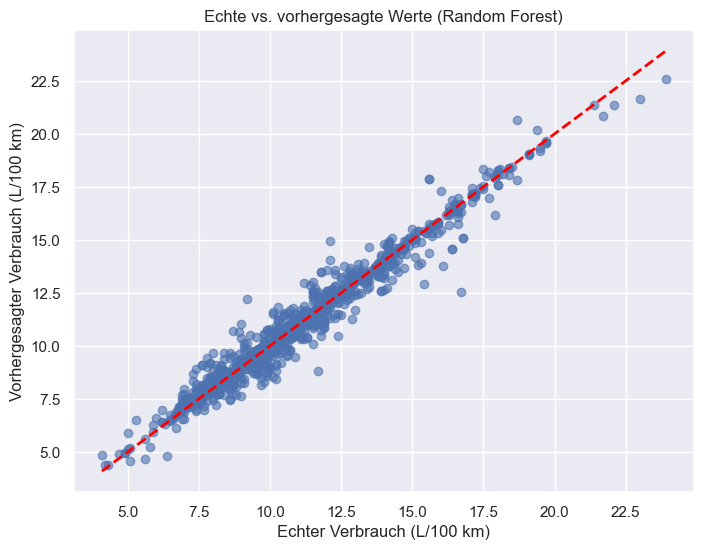

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Vorhersage auf Testdaten
y_pred = rf.predict(X_test)

# Scatterplot echte Werte vs. Vorhersage
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)  # y=x Linie
plt.xlabel("Echter Verbrauch (L/100 km)")
plt.ylabel("Vorhergesagter Verbrauch (L/100 km)")
plt.title("Echte vs. vorhergesagte Werte (Random Forest)")
plt.grid(True)
plt.show()

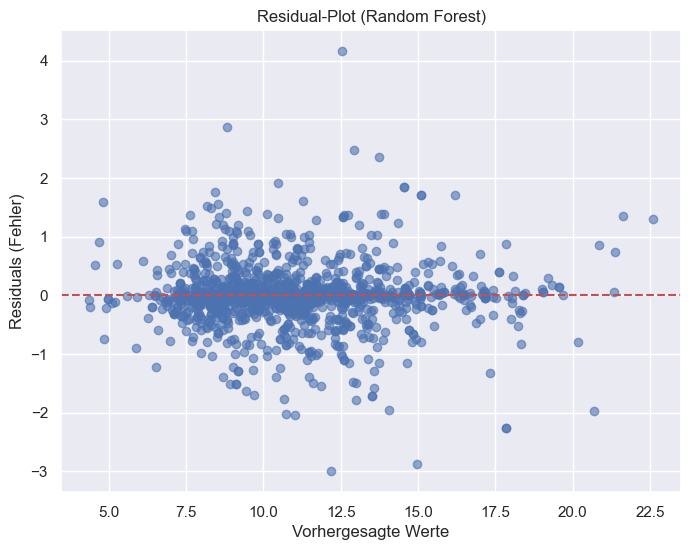

In [43]:
#Residual-Plot erstellen -  wie stark und in welcher Richtung liegt Modell daneben 
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Vorhergesagte Werte")
plt.ylabel("Residuals (Fehler)")
plt.title("Residual-Plot (Random Forest)")
plt.grid(True)
plt.show()

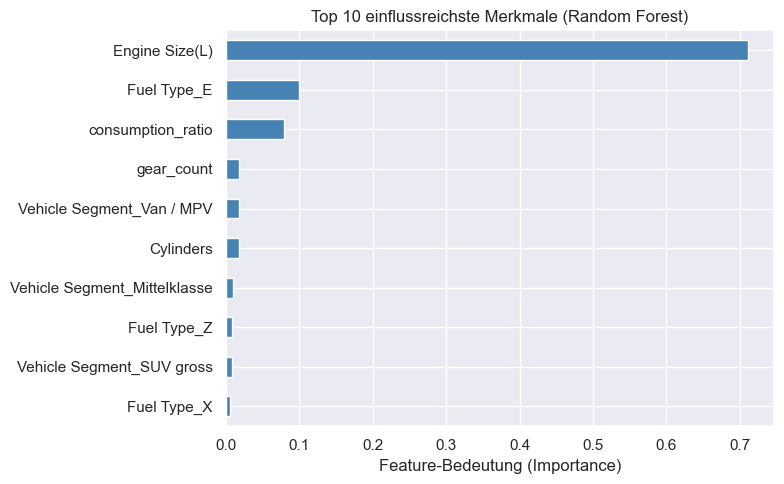

In [44]:
# 7. Feature Importances für Random Forest
import seaborn as sns
sns.set_theme()

importance = pd.Series(rf.feature_importances_, index=X.columns)
top10 = importance.nlargest(10)

plt.figure(figsize=(8, 5))
top10.plot(kind='barh', color='steelblue')
plt.xlabel("Feature-Bedeutung (Importance)")
plt.title("Top 10 einflussreichste Merkmale (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:

import joblib
joblib.dump(rf, "model.pkl")
pd.DataFrame({"columns": X.columns}).to_csv("X_columns.csv", index=False)